# Importando as bibliotecas necessárias

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB

In [ ]:
sns.set_theme()

In [ ]:
RANDOM_SEED = 73
np.random.seed(RANDOM_SEED)

# Carregando os dados

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_list = []
for file in os.listdir('/content/drive/MyDrive/MachineLearningCVE'):
  dataset_aux = pd.read_csv(f'/content/drive/MyDrive/MachineLearningCVE/{file}')
  dataset_list.append(dataset_aux)
dataset = pd.concat(dataset_list, ignore_index=True)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [ ]:
# Retirando espaços desnecessários nos nomes das colunas
def remove_initial_and_ending_spaces(name):
    regex = r'^(?:\s+)?(?P<gp>.+?)(?:\s+)?$'
    mo = re.search(regex, name)
    if mo is not None:
      return mo['gp']
    else:
      print(f'Deu erro em: {name}')
      return name

In [ ]:
for col in dataset.columns:
    dataset = dataset.rename({col:remove_initial_and_ending_spaces(col)}, axis='columns')

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  

# Limpando os dados

In [ ]:
dataset[dataset.duplicated()]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
91,443,3,2,0,91,0,85,6,45.5,55.861436,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
687,80,4,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
690,80,4,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
693,80,4,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1780,80,151,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830685,137,4,2,0,124,0,62,62,62.0,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830694,53,184,2,2,84,310,42,42,42.0,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830696,53,168,2,2,72,194,36,36,36.0,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830704,53,176,2,2,142,242,71,71,71.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
# Descartando duplicadas
initial_len = dataset.shape[0]
dataset = dataset.drop_duplicates()
print(f'Tamanho inicial: {initial_len}, tamanho final {dataset.shape[0]} | Descartadas {initial_len - dataset.shape[0]} duplicadas')

Tamanho inicial: 2830743, tamanho final 2522362 | Descartadas 308381 duplicadas


In [ ]:
dataset.columns[dataset.isna().any(axis=0)]

Index(['Flow Bytes/s'], dtype='object')

In [ ]:
dataset[dataset.isna().any(axis=1)][['Flow Bytes/s']]

,Flow Bytes/s
5106,NaN
5833,NaN
8381,NaN
8552,NaN
14762,NaN
...,...
2577607,NaN
2578213,NaN
2611794,NaN
2619737,NaN


In [ ]:
# Descartando registros com valores NaN/Null/NA
initial_len = dataset.shape[0]
dataset = dataset.dropna()
print(f'Tamanho inicial: {initial_len}, tamanho final {dataset.shape[0]} | Descartados {initial_len - dataset.shape[0]} registros com valores NA')

Tamanho inicial: 2522362, tamanho final 2522009 | Descartados 353 registros com valores NA


In [ ]:
dataset = dataset.reset_index(drop=True)

In [ ]:
dataset_columns_isfinite = np.isfinite(dataset.drop(['Label'], axis='columns')).all(axis=0)
dataset_columns_isfinite[dataset_columns_isfinite == False]

,0
Flow Bytes/s,False
Flow Packets/s,False


In [ ]:
dataset_rows_isfinite = np.isfinite(dataset.drop(['Label'], axis='columns')).all(axis=1)
inf_indexes = dataset_rows_isfinite[dataset_rows_isfinite == False].index
dataset.iloc[inf_indexes][['Flow Bytes/s', 'Flow Packets/s']]

,Flow Bytes/s,Flow Packets/s
1388,inf,inf
2036,inf,inf
2383,inf,inf
3084,inf,inf
3775,inf,inf
...,...,...
2507126,inf,inf
2511105,inf,inf
2511877,inf,inf
2511898,inf,inf


In [ ]:
# Evitando registros com valores não finitos
# Nesse caso uma abordagem válida é substituirmos os mesmos pelo maior valor finito presente no dataset
max_finite_flow_packets_per_sec = dataset[np.isfinite(dataset['Flow Packets/s'])]['Flow Packets/s'].max()
max_finite_flow_bytes_per_sec = dataset[np.isfinite(dataset['Flow Bytes/s'])]['Flow Bytes/s'].max()

dataset.loc[dataset['Flow Packets/s'] == np.inf, 'Flow Packets/s'] = max_finite_flow_packets_per_sec
dataset.loc[dataset['Flow Bytes/s'] == np.inf, 'Flow Bytes/s'] = max_finite_flow_bytes_per_sec

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2522009 entries, 0 to 2522008
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  

# Análise exploratória dos dados

## Quantidade de instâncias benignas x maliciosas

<Axes: xlabel='Label', ylabel='count'>

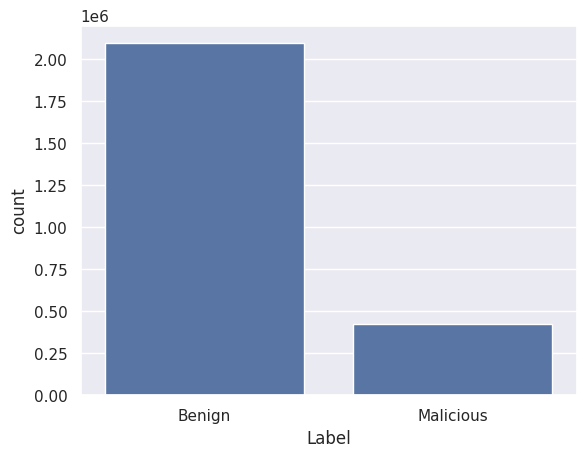

In [ ]:
sns.countplot(data=dataset['Label'].apply(lambda label: 'Malicious' if label != 'BENIGN' else 'Benign').to_frame(), x='Label')

## Quantidade de instâncias por tipo de ataque

In [ ]:
dataset['Label'] = dataset['Label'].replace({'Web Attack � Brute Force':'Brute Force', 'Web Attack � XSS':'XSS', 'Web Attack � Sql Injection':'Sql Injection'})

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'DoS Hulk'),
  Text(1, 0, 'DDoS'),
  Text(2, 0, 'PortScan'),
  Text(3, 0, 'DoS GoldenEye'),
  Text(4, 0, 'FTP-Patator'),
  Text(5, 0, 'DoS slowloris'),
  Text(6, 0, 'DoS Slowhttptest'),
  Text(7, 0, 'SSH-Patator'),
  Text(8, 0, 'Bot'),
  Text(9, 0, 'Brute Force'),
  Text(10, 0, 'XSS'),
  Text(11, 0, 'Infiltration'),
  Text(12, 0, 'Sql Injection'),
  Text(13, 0, 'Heartbleed')])

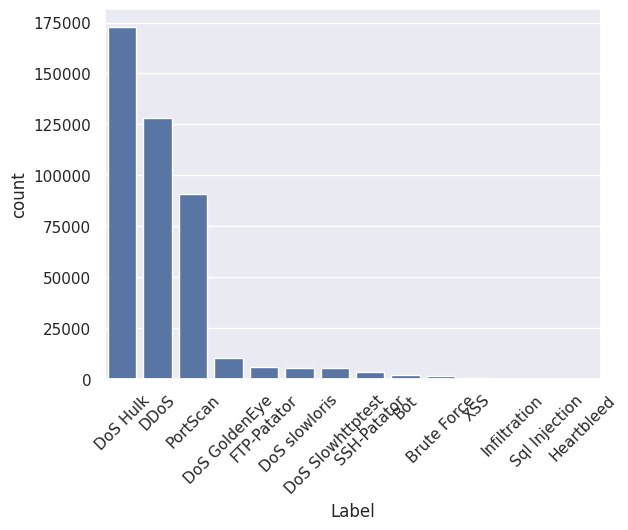

In [ ]:
sns.countplot(data=dataset.query('Label != "BENIGN"')[['Label']], x='Label', order = dataset.query('Label != "BENIGN"')['Label'].value_counts().index)
plt.xticks(rotation=45)

## Ataques menos representados

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Heartbleed'),
  Text(1, 0, 'Brute Force'),
  Text(2, 0, 'XSS'),
  Text(3, 0, 'Sql Injection'),
  Text(4, 0, 'Infiltration')])

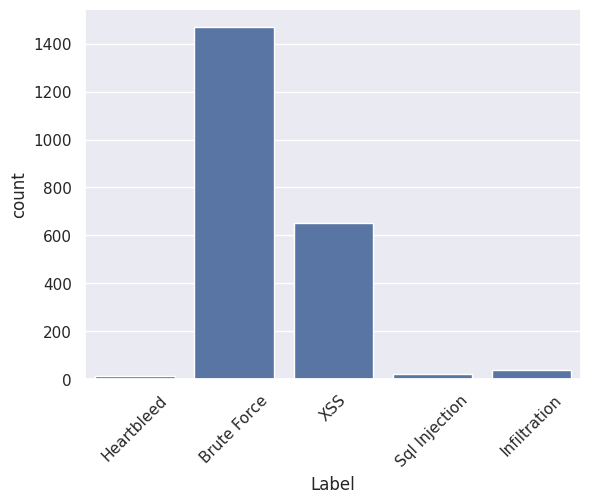

In [ ]:
N_LESS_REPRESENTED_LABELS = 5

sns.countplot(data=dataset[dataset['Label'].isin(dataset.groupby('Label').size().sort_values(ascending=False)[(-1)*N_LESS_REPRESENTED_LABELS:].index)], x='Label')
plt.xticks(rotation=45)

## Análise estatística descritiva dos dados

In [ ]:
dataset.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06,...,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06
mean,8.701432e+03,1.658364e+07,1.027750e+01,1.156751e+01,6.116607e+02,1.813569e+04,2.311241e+02,1.919733e+01,6.347899e+01,7.728840e+01,...,6.006745e+00,-3.080742e+03,9.153450e+04,4.616959e+04,1.719345e+05,6.543215e+04,9.332884e+06,5.655225e+05,9.759082e+06,8.888401e+06
std,1.902225e+04,3.522618e+07,7.942294e+02,1.056668e+03,1.058573e+04,2.397602e+06,7.562104e+02,6.079830e+01,1.955137e+02,2.968147e+02,...,6.742531e+02,1.149482e+06,6.864883e+05,4.164856e+05,1.085317e+06,6.110134e+05,2.484306e+07,4.873014e+06,2.561220e+07,2.457630e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,2.080000e+02,2.000000e+00,1.000000e+00,1.200000e+01,6.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,5.058700e+04,2.000000e+00,2.000000e+00,6.600000e+01,1.560000e+02,4.000000e+01,2.000000e+00,3.613084e+01,0.000000e+00,...,1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,5.330376e+06,6.000000e+00,5.000000e+00,3.320000e+02,9.910000e+02,2.020000e+02,3.700000e+01,5.200000e+01,7.417179e+01,...,3.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


# Dividindo dados nos conjuntos de treino e teste

In [ ]:
X_train, X_test, classes_train, classes_test = train_test_split(dataset.drop('Label', axis='columns'), dataset['Label'], test_size = 0.4, stratify=dataset['Label'], random_state=RANDOM_SEED)

X_train, X_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True)
Y_train, Y_test = classes_train.reset_index(drop=True), classes_test.reset_index(drop=True)

Y_train, Y_test = classes_train.apply(lambda c: 0 if c == 'BENIGN' else 1), classes_test.apply(lambda c: 0 if c == 'BENIGN' else 1)

# Analisando correlação entre features

Vamos descartar features com alta correlação evitando passar informações redundantes ao modelo. Dessa forma, conseguiremos obter um modelo mais simples e com menor custo computacional.

In [ ]:
def get_highly_correlated_features(correlation_matrix, threshold):
  correlated_pairs = []
  for i in range(len(correlation_matrix.columns)):
    for j in range(i):
      if abs(correlation_matrix.iloc[i, j]) > threshold:
        pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
        coefficient = correlation_matrix.iloc[i, j]
        correlated_pairs.append((pair, coefficient))
  return sorted(correlated_pairs, key= lambda pair: pair[1], reverse=True)


In [ ]:
corr_matrix = X_train.corr().abs()
correlation_list = get_highly_correlated_features(corr_matrix, 0.95)

In [ ]:
correlation_list[:10]

[(('Avg Bwd Segment Size', 'Bwd Packet Length Mean'), 1.0000000000000002),
 (('SYN Flag Count', 'Fwd PSH Flags'), 1.0),
 (('CWE Flag Count', 'Fwd URG Flags'), 1.0),
 (('Avg Fwd Segment Size', 'Fwd Packet Length Mean'), 1.0),
 (('Fwd Header Length.1', 'Fwd Header Length'), 1.0),
 (('Subflow Fwd Packets', 'Total Fwd Packets'), 1.0),
 (('Subflow Bwd Packets', 'Total Backward Packets'), 1.0),
 (('Subflow Bwd Bytes', 'Total Length of Bwd Packets'), 0.9999998468295407),
 (('Subflow Fwd Bytes', 'Total Length of Fwd Packets'), 0.9999994246229554),
 (('Total Backward Packets', 'Total Fwd Packets'), 0.9992493903216018)]

In [ ]:
f2drop = []
for feature_pair, _ in correlation_list:
  if feature_pair[0] not in f2drop and feature_pair[1] not in f2drop:
    f2drop.append(feature_pair[1])

In [ ]:
f2drop

['Bwd Packet Length Mean',
 'Fwd PSH Flags',
 'Fwd URG Flags',
 'Fwd Packet Length Mean',
 'Fwd Header Length',
 'Total Fwd Packets',
 'Total Backward Packets',
 'Total Length of Bwd Packets',
 'Total Length of Fwd Packets',
 'Subflow Fwd Packets',
 'Flow Duration',
 'Flow IAT Max',
 'Packet Length Mean',
 'RST Flag Count',
 'Subflow Bwd Packets',
 'Idle Mean',
 'Fwd IAT Max',
 'Max Packet Length',
 'Bwd Packet Length Max',
 'Fwd Packet Length Max',
 'Idle Max']

A feature "Destination Port", também não fornece muita contribuição já que a mesma está codificada com valores inteiros, indicando uma relação de grandeza, como 44720 > 80, que não apresenta sentido semântico quando se trata da porta de destino de um fluxo de rede, por isso vamos removê-la também.

In [ ]:
f2drop = f2drop + ['Destination Port']

In [ ]:
X_train = X_train.drop(f2drop, axis='columns')
X_test = X_test.drop(f2drop, axis='columns')

# Normalizando os dados

É importante normalizar os dados para lidar com diferentes escalas, sensibilidades a escalas e até mesmo melhorar o desempenho da convergência dos algoritmos.

In [ ]:
std_scaler = StandardScaler()
std_scaler = std_scaler.fit(X_train)

norm_X_train = std_scaler.transform(X_train)
norm_X_test = std_scaler.transform(X_test)

In [ ]:
del X_train, X_test

## Métricas

In [ ]:
def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

In [ ]:
def get_tpr_per_attack(y_labels, y_pred):
  aux_dataset = pd.DataFrame({'Label':y_labels,'prediction':y_pred})
  total_per_label = aux_dataset['Label'].value_counts().to_dict()
  correct_predictions_per_label = aux_dataset.query('Label != "BENIGN" and prediction == True').groupby('Label').size().to_dict()
  tpr_per_attack = {}
  for attack_label, total in total_per_label.items():
    if attack_label == 'BENIGN':
      continue
    tp = correct_predictions_per_label[attack_label] if attack_label in correct_predictions_per_label else 0
    tpr = tp/total
    tpr_per_attack[attack_label] = tpr
  return tpr_per_attack

In [ ]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  f1 = (2*tpr*precision)/(tpr+precision)
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

# Detecção de Anomalias com o GaussianNB

---



In [ ]:
#Treinar o Modelo
modelGaussian = GaussianNB()
y_pred_Gaussian = modelGaussian.fit(norm_X_train, Y_train)


In [ ]:
#Fazer previsão com o modelo treinado
predictionsGaussian = modelGaussian.predict(norm_X_test)
print("Número de pontos rotulados incorretamente de um total de %d pontos: %d" % (norm_X_test.shape[0], (Y_test != predictionsGaussian).sum()))

Número de pontos rotulados incorretamente de um total de 1008804 pontos: 546185


In [ ]:
#Avaliar o modelo
print("Classification Report:\n", classification_report(Y_test, predictionsGaussian))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.35      0.52    838454
           1       0.24      0.98      0.38    170350

    accuracy                           0.46   1008804
   macro avg       0.61      0.67      0.45   1008804
weighted avg       0.86      0.46      0.50   1008804



In [ ]:
get_overall_metrics(Y_test, predictionsGaussian)

{'acc': 0.45858164717824274,
 'tpr': 0.9817728206633402,
 'fpr': 0.6477159152440086,
 'precision': 0.23544856227783056,
 'f1-score': 0.3798109404717972}

In [ ]:
get_tpr_per_attack(classes_test, predictionsGaussian)

{'DoS Hulk': 0.9975845759990744,
 'DDoS': 0.9994531997578456,
 'PortScan': 0.9801255230125523,
 'DoS GoldenEye': 0.9927078269324259,
 'FTP-Patator': 0.9957859249894648,
 'DoS slowloris': 0.765552460538533,
 'DoS Slowhttptest': 0.8067910090865614,
 'SSH-Patator': 0.9262422360248447,
 'Bot': 0.5902688860435339,
 'Brute Force': 0.05272108843537415,
 'XSS': 0.03065134099616858,
 'Infiltration': 0.5714285714285714,
 'Sql Injection': 0.5,
 'Heartbleed': 0.0}

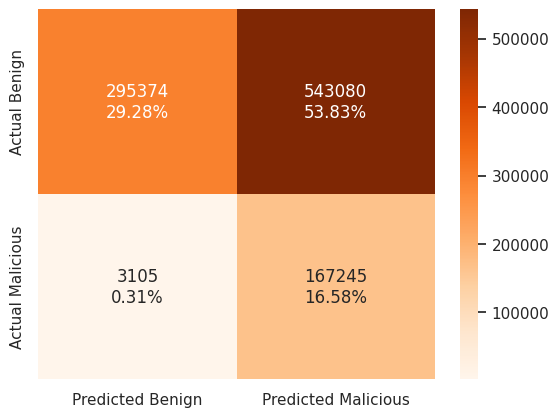

In [ ]:
plot_confusion_matrix(Y_test, predictionsGaussian)

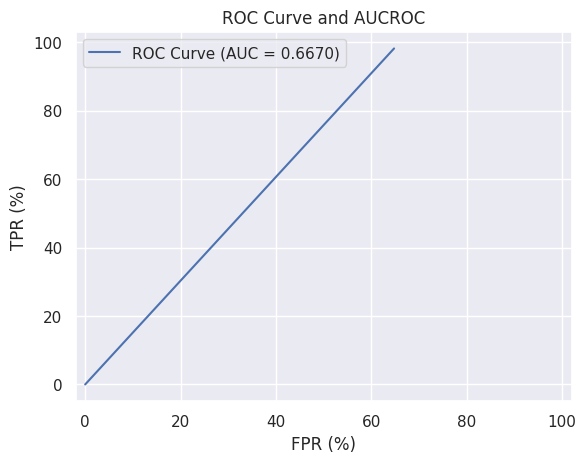

In [ ]:
plot_roc_curve(Y_test, predictionsGaussian)

# Detecção de Anomalias com o BernoulliNB

---



In [ ]:
#Treinar o Modelo
modelBernoulli = BernoulliNB()
y_pred_Bernoulli = modelBernoulli.fit(norm_X_train, Y_train)


In [ ]:
#Fazer previsão com o modelo treinado
predictionsBernoulli = modelBernoulli.predict(norm_X_test)
print("Número de pontos rotulados incorretamente de um total de %d pontos: %d" % (norm_X_test.shape[0], (Y_test != predictionsBernoulli).sum()))

Número de pontos rotulados incorretamente de um total de 1008804 pontos: 183759


In [ ]:
#Avaliar o modelo
print("Classification Report:\n", classification_report(Y_test, predictionsBernoulli))

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.89    838454
           1       0.47      0.64      0.54    170350

    accuracy                           0.82   1008804
   macro avg       0.70      0.75      0.71   1008804
weighted avg       0.84      0.82      0.83   1008804



In [ ]:
get_overall_metrics(Y_test, predictionsBernoulli)

{'acc': 0.8178446953025563,
 'tpr': 0.636278250660405,
 'fpr': 0.14526616844812,
 'precision': 0.4708739340281247,
 'f1-score': 0.5412207050998779}

In [ ]:
get_tpr_per_attack(classes_test, predictionsBernoulli)

{'DoS Hulk': 0.8989137823804221,
 'DDoS': 0.7909856074364833,
 'PortScan': 0.0033032371724289805,
 'DoS GoldenEye': 0.9467671366067087,
 'FTP-Patator': 0.0,
 'DoS slowloris': 0.04503249767873723,
 'DoS Slowhttptest': 0.7685318029650885,
 'SSH-Patator': 0.0,
 'Bot': 0.002560819462227913,
 'Brute Force': 0.003401360544217687,
 'XSS': 0.022988505747126436,
 'Infiltration': 0.07142857142857142,
 'Sql Injection': 0.375,
 'Heartbleed': 0.75}

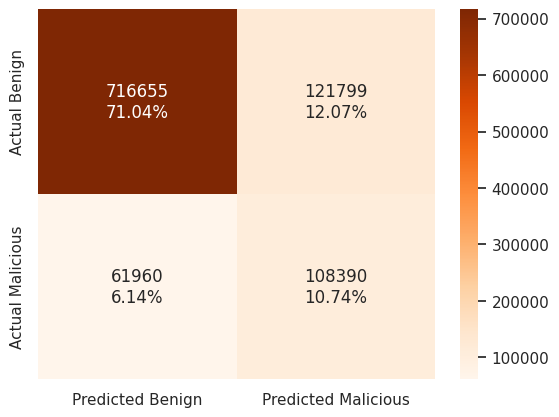

In [ ]:
plot_confusion_matrix(Y_test, predictionsBernoulli)

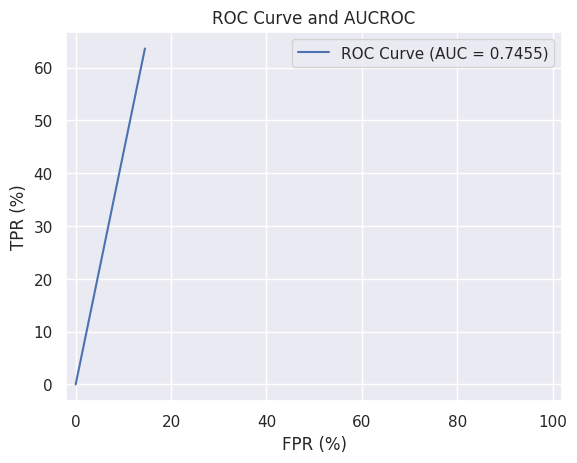

In [ ]:
plot_roc_curve(Y_test, predictionsBernoulli)

Não treinamos através de MultinomialNB, ComplementNB, CategorialNB porque esses modelos só aceitam valores não-negativos.